In [1]:
# https://platform.olimpiada-ai.ro/problems/66

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [2]:
train = pd.read_csv("/kaggle/input/saving-xmas/train.csv")
test = pd.read_csv('/kaggle/input/saving-xmas/test.csv')

train['image_path'] = '/kaggle/input/saving-xmas/' + train['image_path']
test['image_path'] = '/kaggle/input/saving-xmas/' + test['image_path']

train.shape, test.shape

((200, 2), (100, 1))

In [3]:
train.head()

,image_path,number
0,/kaggle/input/saving-xmas/images/image_0214.png,0
1,/kaggle/input/saving-xmas/images/image_0187.png,4
2,/kaggle/input/saving-xmas/images/image_0000.png,0
3,/kaggle/input/saving-xmas/images/image_0262.png,5
4,/kaggle/input/saving-xmas/images/image_0082.png,3


In [4]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, stratify=train['number'], random_state=42, test_size=0.2)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.is_test = is_test
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img = Image.open(self.df['image_path'][idx])
        if self.transform is not None:
            img = self.transform(img)
        if self.is_test:
            return img
            
        label = self.df['number'][idx]
        return img, label

transform = v2.Compose([
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
])

train_ds = CustomDataset(train, transform=transform)
valid_ds = CustomDataset(valid, transform=transform)
test_ds = CustomDataset(test, transform=transform, is_test=True)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

len(train_loader), len(valid_loader), len(test_loader)

(5, 2, 4)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def custom_metric(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)
    cnt = np.bincount(abs_diff)[:4]
    w = [1, 1, 0.5, 0.25]
    score = 0
    for i, c in enumerate(cnt):
        score += c * w[i]
    return score
    

def train(model, loss_fn, optimizer, train_loader, valid_loader, device, epochs=10, log_rate=1):
    train_losses, valid_losses, valid_metrics = [], [], []
    for epoch in tqdm(range(epochs), desc='Epoch'):
        model.train()
        running_train_loss, i = 0, 0
        for X, y in (pbar := tqdm(train_loader, desc='Train DataLoader', leave=False)):
            X, y = X.to(device), y.float().to(device)
            output = model(X).squeeze()
            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            i += 1
            running_train_loss += loss.item()
            pbar.set_postfix({'loss': f'{running_train_loss/i:.5f}'})

        train_losses.append(running_train_loss/i)
        if (epoch+1)%log_rate==0:
            print(f'Epoch: {epoch+1} | Train Loss: {running_train_loss/i:.5f}')
        
        model.eval()
        running_valid_loss, running_valid_metric, max_valid_metric, i = 0, 0, 0, 0
        for X, y in (pbar := tqdm(valid_loader, desc='Valid DataLoader', leave=False)):
            X, y = X.to(device), y.float().to(device)
            with torch.no_grad():
                output = model(X).squeeze()
                loss = loss_fn(output, y)

            i += 1
            running_valid_loss += loss.item()
            running_valid_metric += custom_metric(y.cpu().numpy().flatten().astype(int), np.round(output.cpu().numpy()).flatten().astype(int))
            max_valid_metric += len(y)
            pbar.set_postfix({'loss': f'{running_valid_loss/i:.5f}', 'metric': f'{running_valid_metric/i:.5f}'})
            
        valid_losses.append(running_valid_loss/i)
        valid_metrics.append(running_valid_metric/i)
        if (epoch+1)%log_rate==0:
            print(f'Valid Loss: {running_valid_loss/i:.5f} | Valid Metric: {running_valid_metric/i:.5f} ({running_valid_metric/max_valid_metric:.5f}%)')
            
    return train_losses, valid_losses, valid_metrics

In [8]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=1)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 199MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
train_losses, valid_losses, valid_metrics = train(model, loss_fn, optimizer, 
                                                  train_loader, valid_loader,
                                                  device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 3.83441


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 2.82224 | Valid Metric: 14.12500 (0.70625%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 2.62618


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 2.83779 | Valid Metric: 15.87500 (0.79375%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 2.06092


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 1.59594 | Valid Metric: 17.37500 (0.86875%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 1.18009


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 1.24234 | Valid Metric: 17.62500 (0.88125%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 0.78583


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.85408 | Valid Metric: 19.12500 (0.95625%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.74045


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.66759 | Valid Metric: 19.50000 (0.97500%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.60453


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.40581 | Valid Metric: 19.75000 (0.98750%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.59175


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.75111 | Valid Metric: 19.12500 (0.95625%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.65107


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.53673 | Valid Metric: 19.50000 (0.97500%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.49991


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.46264 | Valid Metric: 19.50000 (0.97500%)


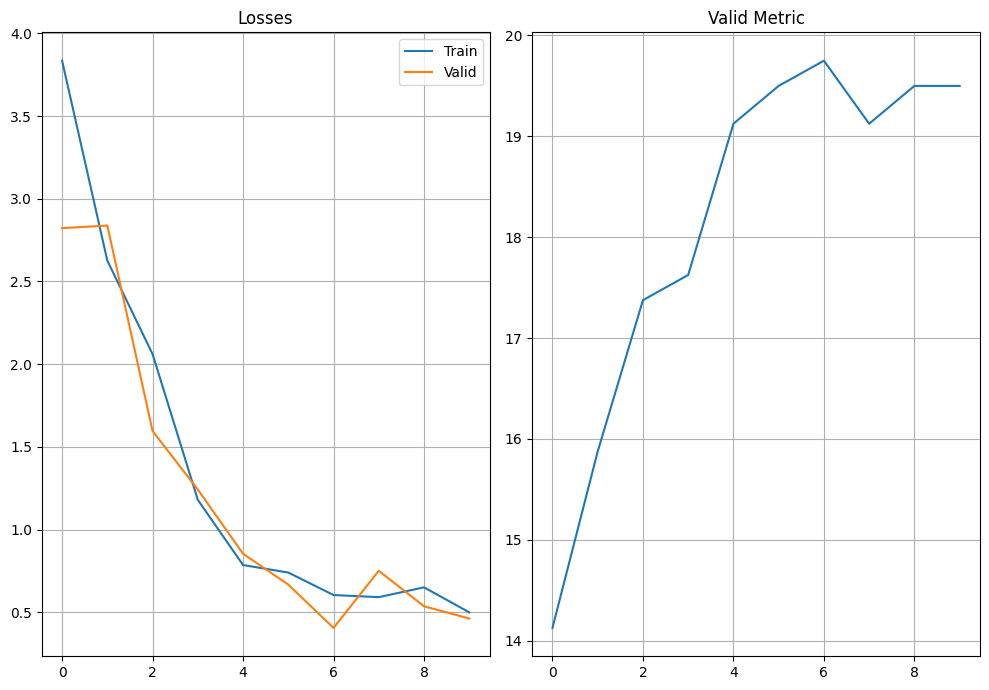

In [12]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Valid Metric')
plt.plot(range(len(valid_metrics)), valid_metrics)
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
predictions = []

model.eval()
for X in (pbar := tqdm(test_loader, desc='Test DataLoader', leave=True)):
    X = X.to(device)
    with torch.no_grad():
        output = model(X).squeeze()
    preds = np.round(output.cpu().numpy()).flatten().astype(int)
    predictions.append(preds)

predictions = np.concatenate(predictions)

Test DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
orig_test = pd.read_csv("/kaggle/input/saving-xmas/test.csv")

subm = pd.DataFrame({
    'image_path': orig_test['image_path'],
    'number': predictions
})

subm.to_csv("submission.csv", index=False)
subm.head()

,image_path,number
0,images/image_0119.png,1
1,images/image_0227.png,0
2,images/image_0160.png,3
3,images/image_0091.png,0
4,images/image_0141.png,5


In [22]:
subm['number'].value_counts()

number
3    27
4    19
0    17
1    15
2    12
5    10
Name: count, dtype: int64